Ref
- https://github.com/philipperemy/keras-attention-mechanism

In [1]:
# can attention model figure out dependent variable
# ex) v = vector with 32 values
# v[1] == target & all other values are randomly chosen
# can the model understand the importance of v[1]?

In [2]:
import numpy as np
from keras import backend as K
from keras.models import *
from keras.layers import Input, Dense, multiply
from keras.layers.recurrent import LSTM
from keras.layers.core import *
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [3]:
data_c = 10000
input_dims = 32
attention_column = 7

In [4]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    activations = []
#     inp =  model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name==layer_name]
    
    funcs = [K.function([model.input] + [K.learning_phase()], [out]) for out in outputs]
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
        return activations

In [5]:
def generate_date(batch_size, input_size, attention_index):
    train_x = np.random.standard_normal(size=(batch_size, input_size))
    train_y = np.random.randint(low=0, high=2, size=(batch_size, 1))
    train_x[:, attention_index] = train_y[:, 0]
    return (train_x, train_y)

train_x, train_y = generate_date(data_c, input_dims, attention_column)
test_x, test_y = generate_date(1, input_dims, attention_column)

### Dense- Attention

In [6]:
def build_model():
    # input layer
    input_layer = Input(shape=(input_dims,))
    
    # attention layer
    attention_prob = Dense(input_dims, activation='softmax', name='attention_vec')(input_layer)
    attention_mul = multiply([input_layer, attention_prob])
    
    # fully connected layer
    y = Dense(64)(attention_mul)
    y = Dense(1, activation='sigmoid')(y)
    
    model = Model(input_layer, y)
    return model

In [7]:
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 32)           0           input_1[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        multiply_1[0][0]                 
__________

In [9]:
model.fit(train_x, train_y, epochs=10, batch_size=64, validation_split=0.2, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 0s - loss: 0.6680 - acc: 0.6839 - val_loss: 0.6252 - val_acc: 0.7510
Epoch 2/10
 - 0s - loss: 0.5514 - acc: 0.7805 - val_loss: 0.4711 - val_acc: 0.8015
Epoch 3/10
 - 0s - loss: 0.3825 - acc: 0.8449 - val_loss: 0.3083 - val_acc: 0.8760
Epoch 4/10
 - 0s - loss: 0.2046 - acc: 0.9336 - val_loss: 0.1283 - val_acc: 0.9725
Epoch 5/10
 - 0s - loss: 0.0602 - acc: 0.9938 - val_loss: 0.0279 - val_acc: 0.9980
Epoch 6/10
 - 0s - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 7/10
 - 0s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 8/10
 - 0s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 9/10
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 10/10
 - 0s - loss: 9.5682e-04 - acc: 1.0000 - val_loss: 9.5755e-04 - val_acc: 1.0000


In [10]:
result = model.evaluate(test_x, test_y, batch_size=64, verbose=0)

In [11]:
# loss
result[0]

0.00041113165207207203

In [12]:
# accuracy
result[1]

1.0

In [13]:
# get attention vector
model.layers

In [14]:
attention_vector = get_activations(model, test_x, print_shape_only=True, layer_name='attention_vec')[0].flatten()

(1, 32)


In [15]:
attention_vector

array([0.02289751, 0.02096518, 0.01442362, 0.02884816, 0.0441886 ,
       0.03433975, 0.0292863 , 0.19075838, 0.01404408, 0.01838223,
       0.02153056, 0.03378483, 0.02276736, 0.03660168, 0.01472947,
       0.03497808, 0.02677642, 0.02260434, 0.01876842, 0.02274726,
       0.01601109, 0.02707124, 0.03869854, 0.02701417, 0.04836982,
       0.04623525, 0.02058522, 0.02393275, 0.02748605, 0.00848371,
       0.02176566, 0.02092426], dtype=float32)

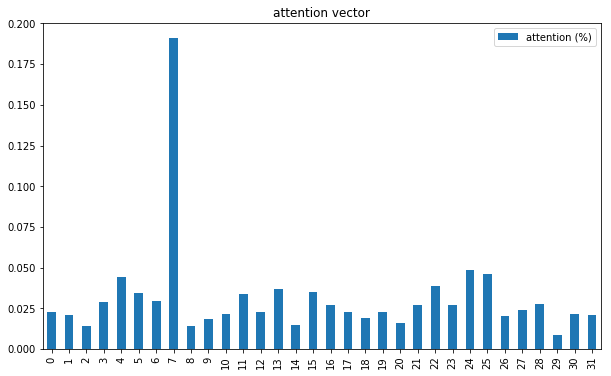

In [16]:
pd.DataFrame(attention_vector, columns=['attention (%)']).plot(figsize=(10, 6), kind='bar', title='attention vector')
# plt.show()

### LSTM - Attention

In [17]:
data_c = 300000
input_dims = 2
time_steps = 20
# true = attention vector is shared across the input_dimensions
SINGEL_ATTENTION_VECTOR = False

APPLY_ATTENTION_BEFORE_LSTM = False

In [18]:
def generate_recurrent_data(batch_size, time_steps, input_dims, attention_columns=10):
    train_x = np.random.standard_normal(size=(batch_size, time_steps, input_dims))
    train_y = np.random.randint(low=0, high=2, size=(batch_size, 1))
    train_x[:, attention_column, :] = np.tile(train_y[:], (1, input_dims))
    return train_x, train_y

train_rx, train_ry = generate_recurrent_data(data_c, time_steps, input_dims)

In [20]:
def attention_3d_block(time_steps, input_layer, single_attention_vector):
    input_dim = int(input_layer.shape[2])
    a = Permute((2, 1))(input_layer)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    
#     a_probs = Permute((2, 1), name='attention_vec')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([input_layer, a_probs], name='attention_vec')
    return output_attention_mul
    
#     https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py

In [21]:
def model_atten_before_lstm(time_steps, input_dims):
    input_layer = Input(shape=(time_steps, input_dims))
    attention_mul = attention_3d_block(time_steps, input_layer, SINGEL_ATTENTION_VECTOR)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=True)(input_layer)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[input_layer], output=output)
    return model

def model_atten_after_lstm(time_steps, input_dims):
    input_layer = Input(shape=(time_steps, input_dims, ))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(input_layer)
    attention_mul = attention_3d_block(time_steps, lstm_out, SINGEL_ATTENTION_VECTOR)
    attention_mul  = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[input_layer], output=output)
    return model

In [22]:
if APPLY_ATTENTION_BEFORE_LSTM:
    model = model_atten_before_lstm(time_steps, input_dims)
else:
    model = model_atten_after_lstm(time_steps, input_dims)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/madigun/.pyenv/versions/3.6.7/envs/grace_jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 20, 32)       4480        input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 32, 20)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 20)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_3 (D

In [24]:
attention_vectors = []
for i in range(300):
    test_rx, test_ry = generate_recurrent_data(1, time_steps, input_dims)
    attention_vector = np.mean(get_activations(model, test_rx, print_shape_only=True, layer_name='attention_vec')[0], axis=2).squeeze()
    if i % 50 ==0:
        print('attention = ', attention_vector)
        assert(np.sum(attention_vector)-1.0) < 1e-5
    attention_vectors.append(attention_vector)

(1, 20, 32)
attention =  [-5.3656389e-05 -5.0731783e-04 -6.4736779e-04 -4.8052781e-04
 -3.2855410e-04 -1.3153530e-03 -1.2844584e-03 -1.9654939e-03
 -2.3176959e-03 -1.4952979e-03 -1.0755355e-03 -1.0644926e-04
 -2.4605691e-04 -5.3038355e-04 -1.2090511e-03 -3.6297046e-04
 -1.7500823e-04 -5.9797452e-04 -1.5760114e-04  5.3326320e-04]
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
(1, 20, 32)
attention =  [-2.63487163e-05  9.47667053e-04 -3.95709561e-04 -1.2367

In [26]:
attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

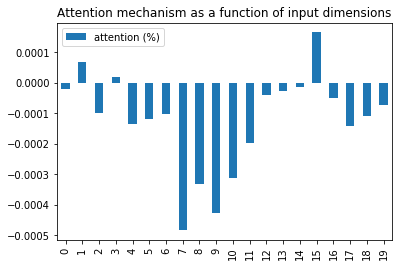

In [27]:
pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                    title='Attention mechanism as a function of input dimensions')

In [ ]:
# https://nlp.stanford.edu/projects/tacred/
# tacred + keras + attention